In [3]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import wandb
import time
from tesladatamlp import TeslaDatasetMlp

# Import PINNFramework etc.
# https://github.com/ComputationalRadiationPhysics/NeuralSolvers.git
sys.path.append("...")  
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [5]:
# Use cuda if it is available, else use the cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocessing

In [6]:
# login wandb (optional)
# wandb.login()

# # Initialize WandB (optional)
# wandb.init(name='mlp_run_test', 
#            project='MLP_project',
#            #notes='...', 
#            #tags=['...'],
#            #entity='...'
#            )


# WandB Configurations (optional)
wandb.config.batch_size=1024       
wandb.config.lr = 1e-4

# Create instance of the dataset
ds = TeslaDatasetMlp(device = device, data = "train")

# trainloader
trainloader = DataLoader(ds, batch_size=wandb.config.batch_size,shuffle=True)


# MLP model

model = pf.models.MLP(input_size=4,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=ds.lb, 
                      ub=ds.ub)

model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.lr)
criterion = torch.nn.MSELoss()

# # Log the network weight histograms (optional)
# wandb.watch(model)

In [ ]:
# function for saving checkpoints during training
def write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer):
    checkpoint = {}
    checkpoint["epoch"] = epoch
    checkpoint["minimum_mlp_loss"] = min_mlp_loss
    checkpoint["optimizer"] = optimizer.state_dict()
    checkpoint["mlp_model"] = model.state_dict()
    torch.save(checkpoint, checkpoint_path)

## Training

In [ ]:
epochs = 2000
min_mlp_loss = np.inf
x_data_plot=[]
y_data_plot=[]

# Set fixed random number seed
torch.manual_seed(1234)

begin = time.time()
for epoch in range(epochs):
    # Print epoch
    print(f'Starting epoch {epoch}')

    # Set current and total loss value
    current_loss = 0.0
    total_loss = 0.0

    model.train() 
    for i, data in enumerate(trainloader,0):
        x_batch, y_batch = data     
        optimizer.zero_grad()
        target = model(x_batch.to(device))
        loss = criterion(target,y_batch.to(device))
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        total_loss += loss.item()

        if i % 50 == 49:
            print('Loss after mini-batch %5d: %.8f' %
                  (i + 1, current_loss / 50))
            current_loss = 0.0
    Loss = total_loss/(i+1)
    print("Epoch ", epoch, "Total Loss ", Loss)
    x_data_plot.append(epoch)
    y_data_plot.append(Loss)

    #uncomment for saving/tracking the best model and checkpoints
    # # save best model
    # if min_mlp_loss > Loss:
    #     print(f'Loss Decreased({min_mlp_loss:.6f}--->{Loss:.6f}) \t Saving The Model')
    #     min_mlp_loss = Loss
    #     # Saving State Dict
    #     model_name_path = Path('/mlpmodel/best_model_{}_{}.pt'.format(wandb.run.id, wandb.run.name))
    #     torch.save(model.state_dict(), model_name_path)

    # # writing checkpoint
    # if (epoch + 1) % 200 == 0:
    #     checkpoint_path = Path('/mlpmodel/checkpoint_{}_{}_{}.pt'.format(wandb.run.id, wandb.run.name, epoch))
    #     write_checkpoint(checkpoint_path, epoch, min_mlp_loss, optimizer)

    # # Log the loss and accuracy values at the end of each epoch
    # wandb.log({
    #     "Epoch": epoch,
    #     "Total Loss": Loss,
    #     })
end = time.time()
print("Training time:", end - begin)

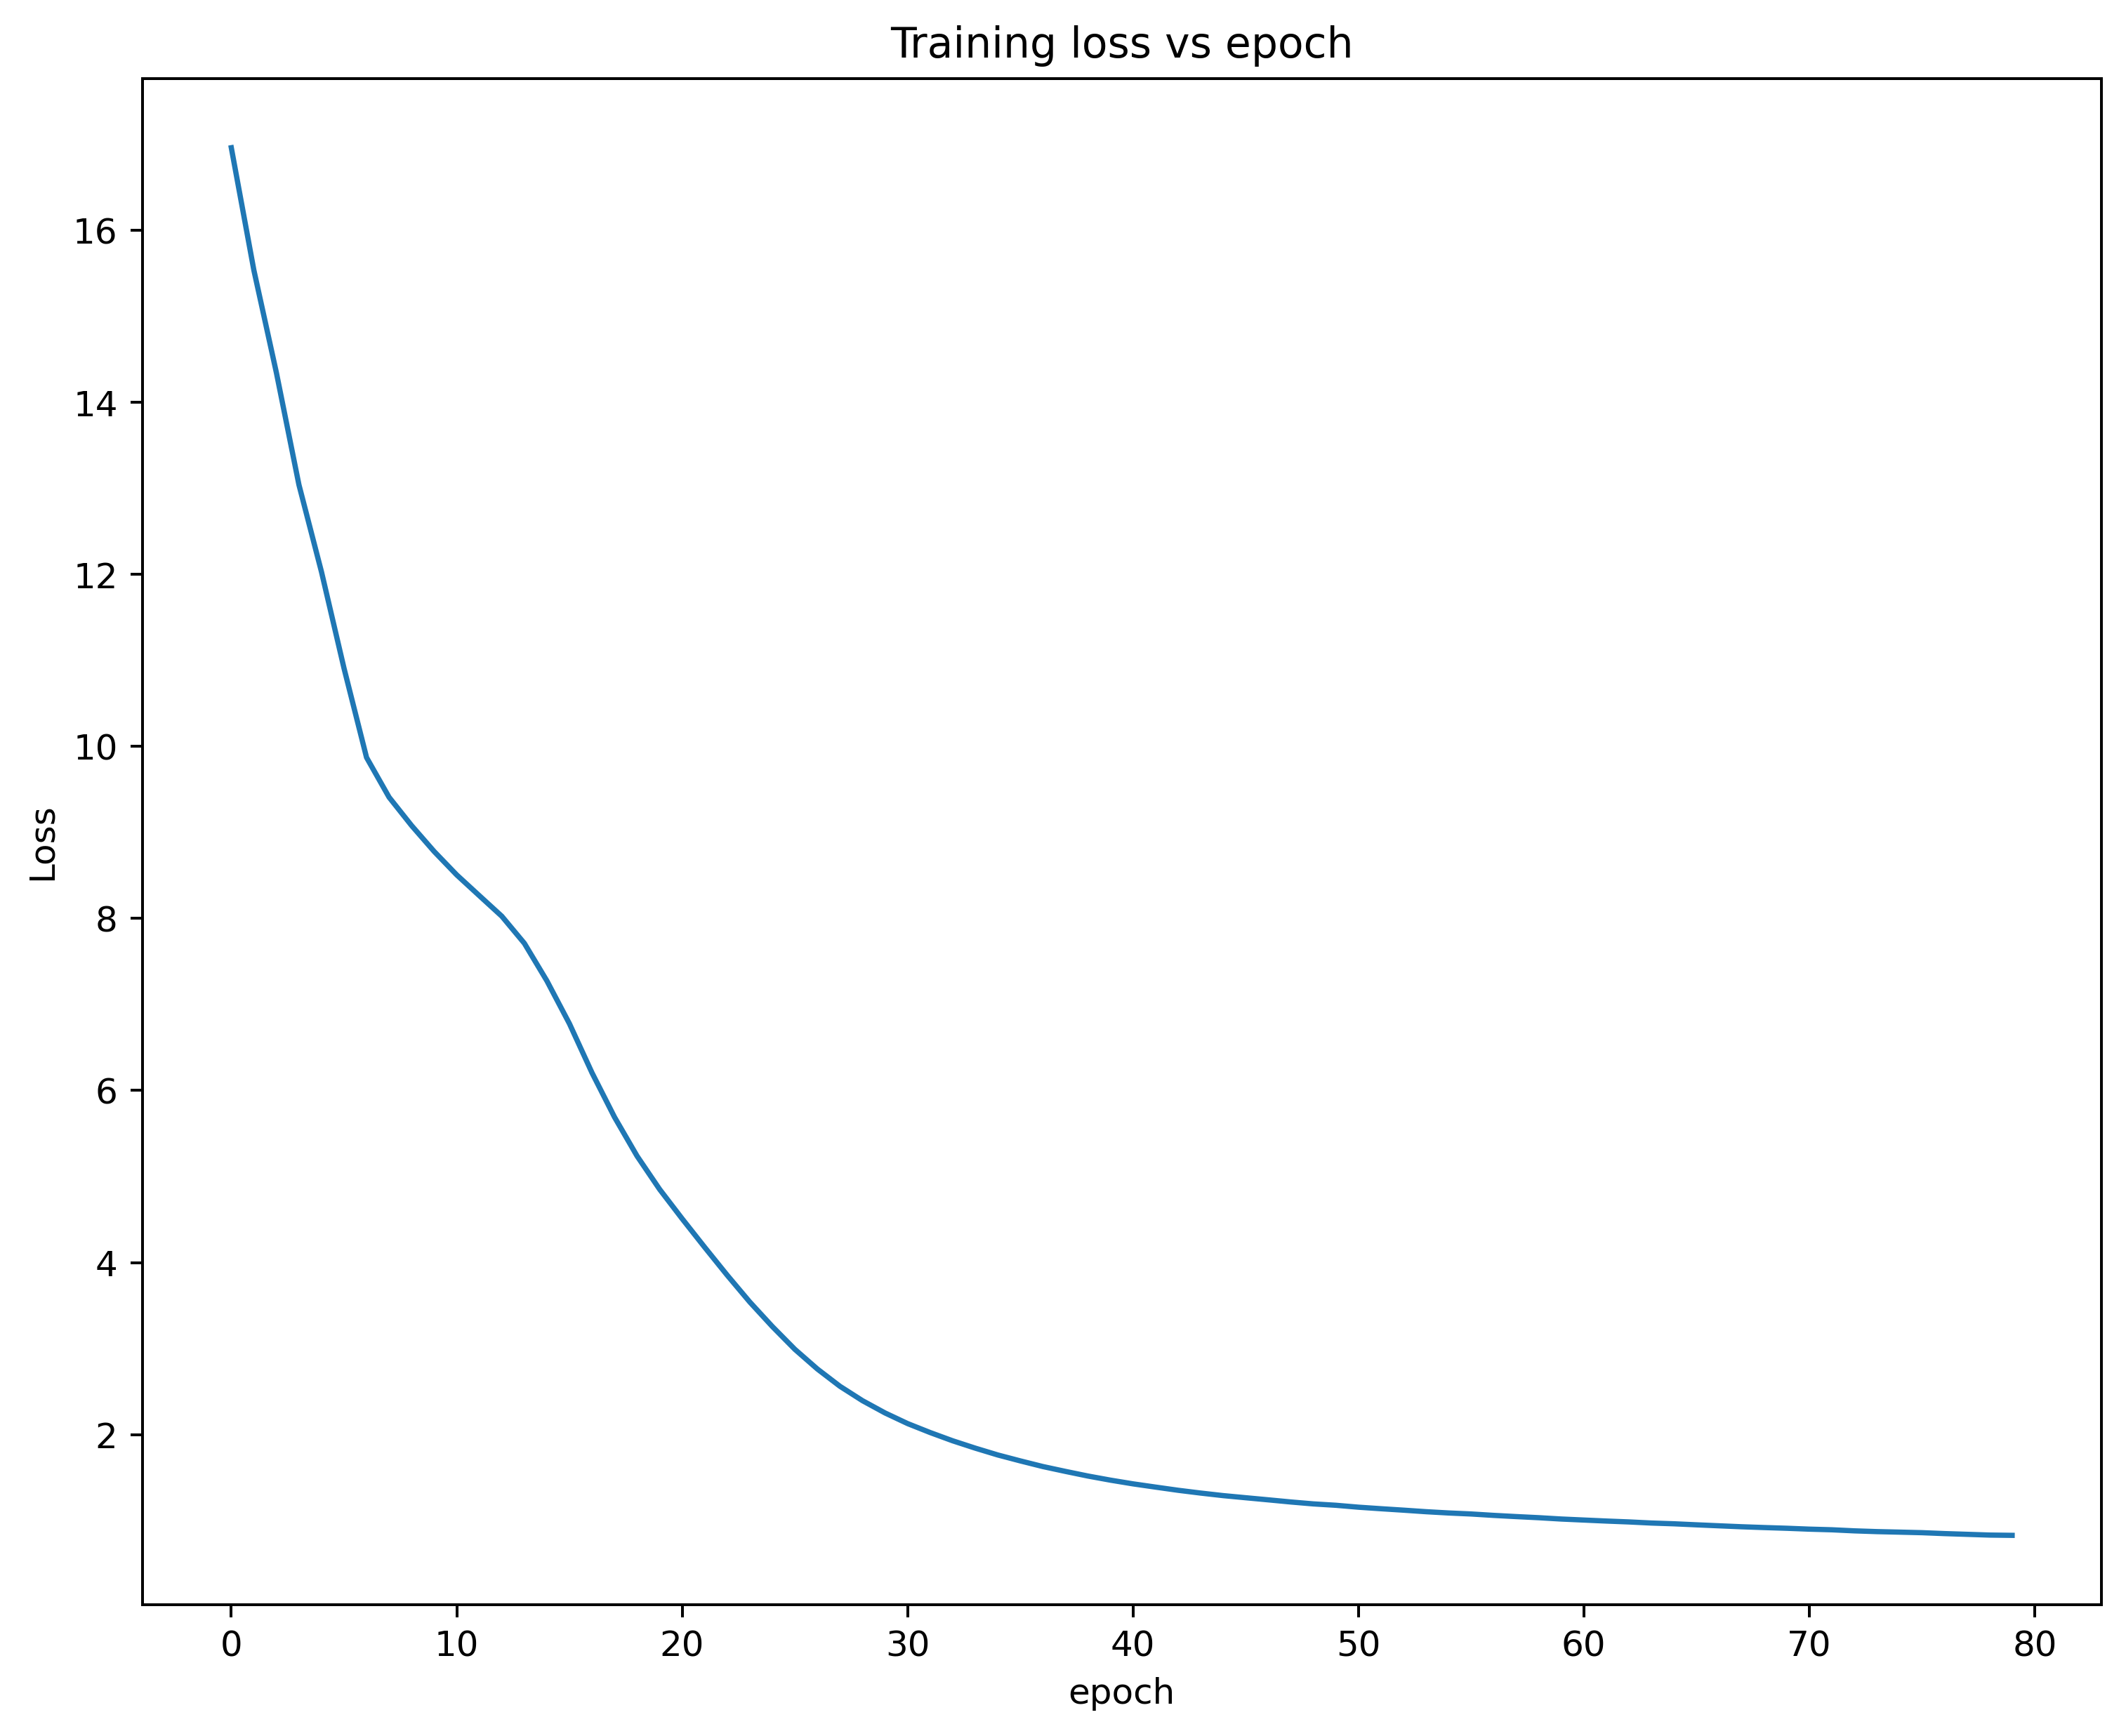

In [ ]:
# Make the plot of Total Loss vs epochs
dpi = 360
figure(figsize=(10, 8), dpi = dpi)

plt.plot(x_data_plot,y_data_plot)
plt.title('Training loss vs epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

## Postprocessing

1) Load the best model


In [12]:
# Load the best model
#PATH = '/mlpmodel/best_model_{}_{}.pt'.format(wandb.run.id, wandb.run.name)
PATH ='/models/best_model_3a0z7dct_mlp_run.pt'
model.load_state_dict(torch.load(PATH))
#model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu'))) # if there is no gpu available
model.eval()

MLP(
  (linear_layers): ModuleList(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)

2. Performance on the training data

MAE: 0.13675006
MSE: 0.18828242
Relative error (%): 2.038017101585865


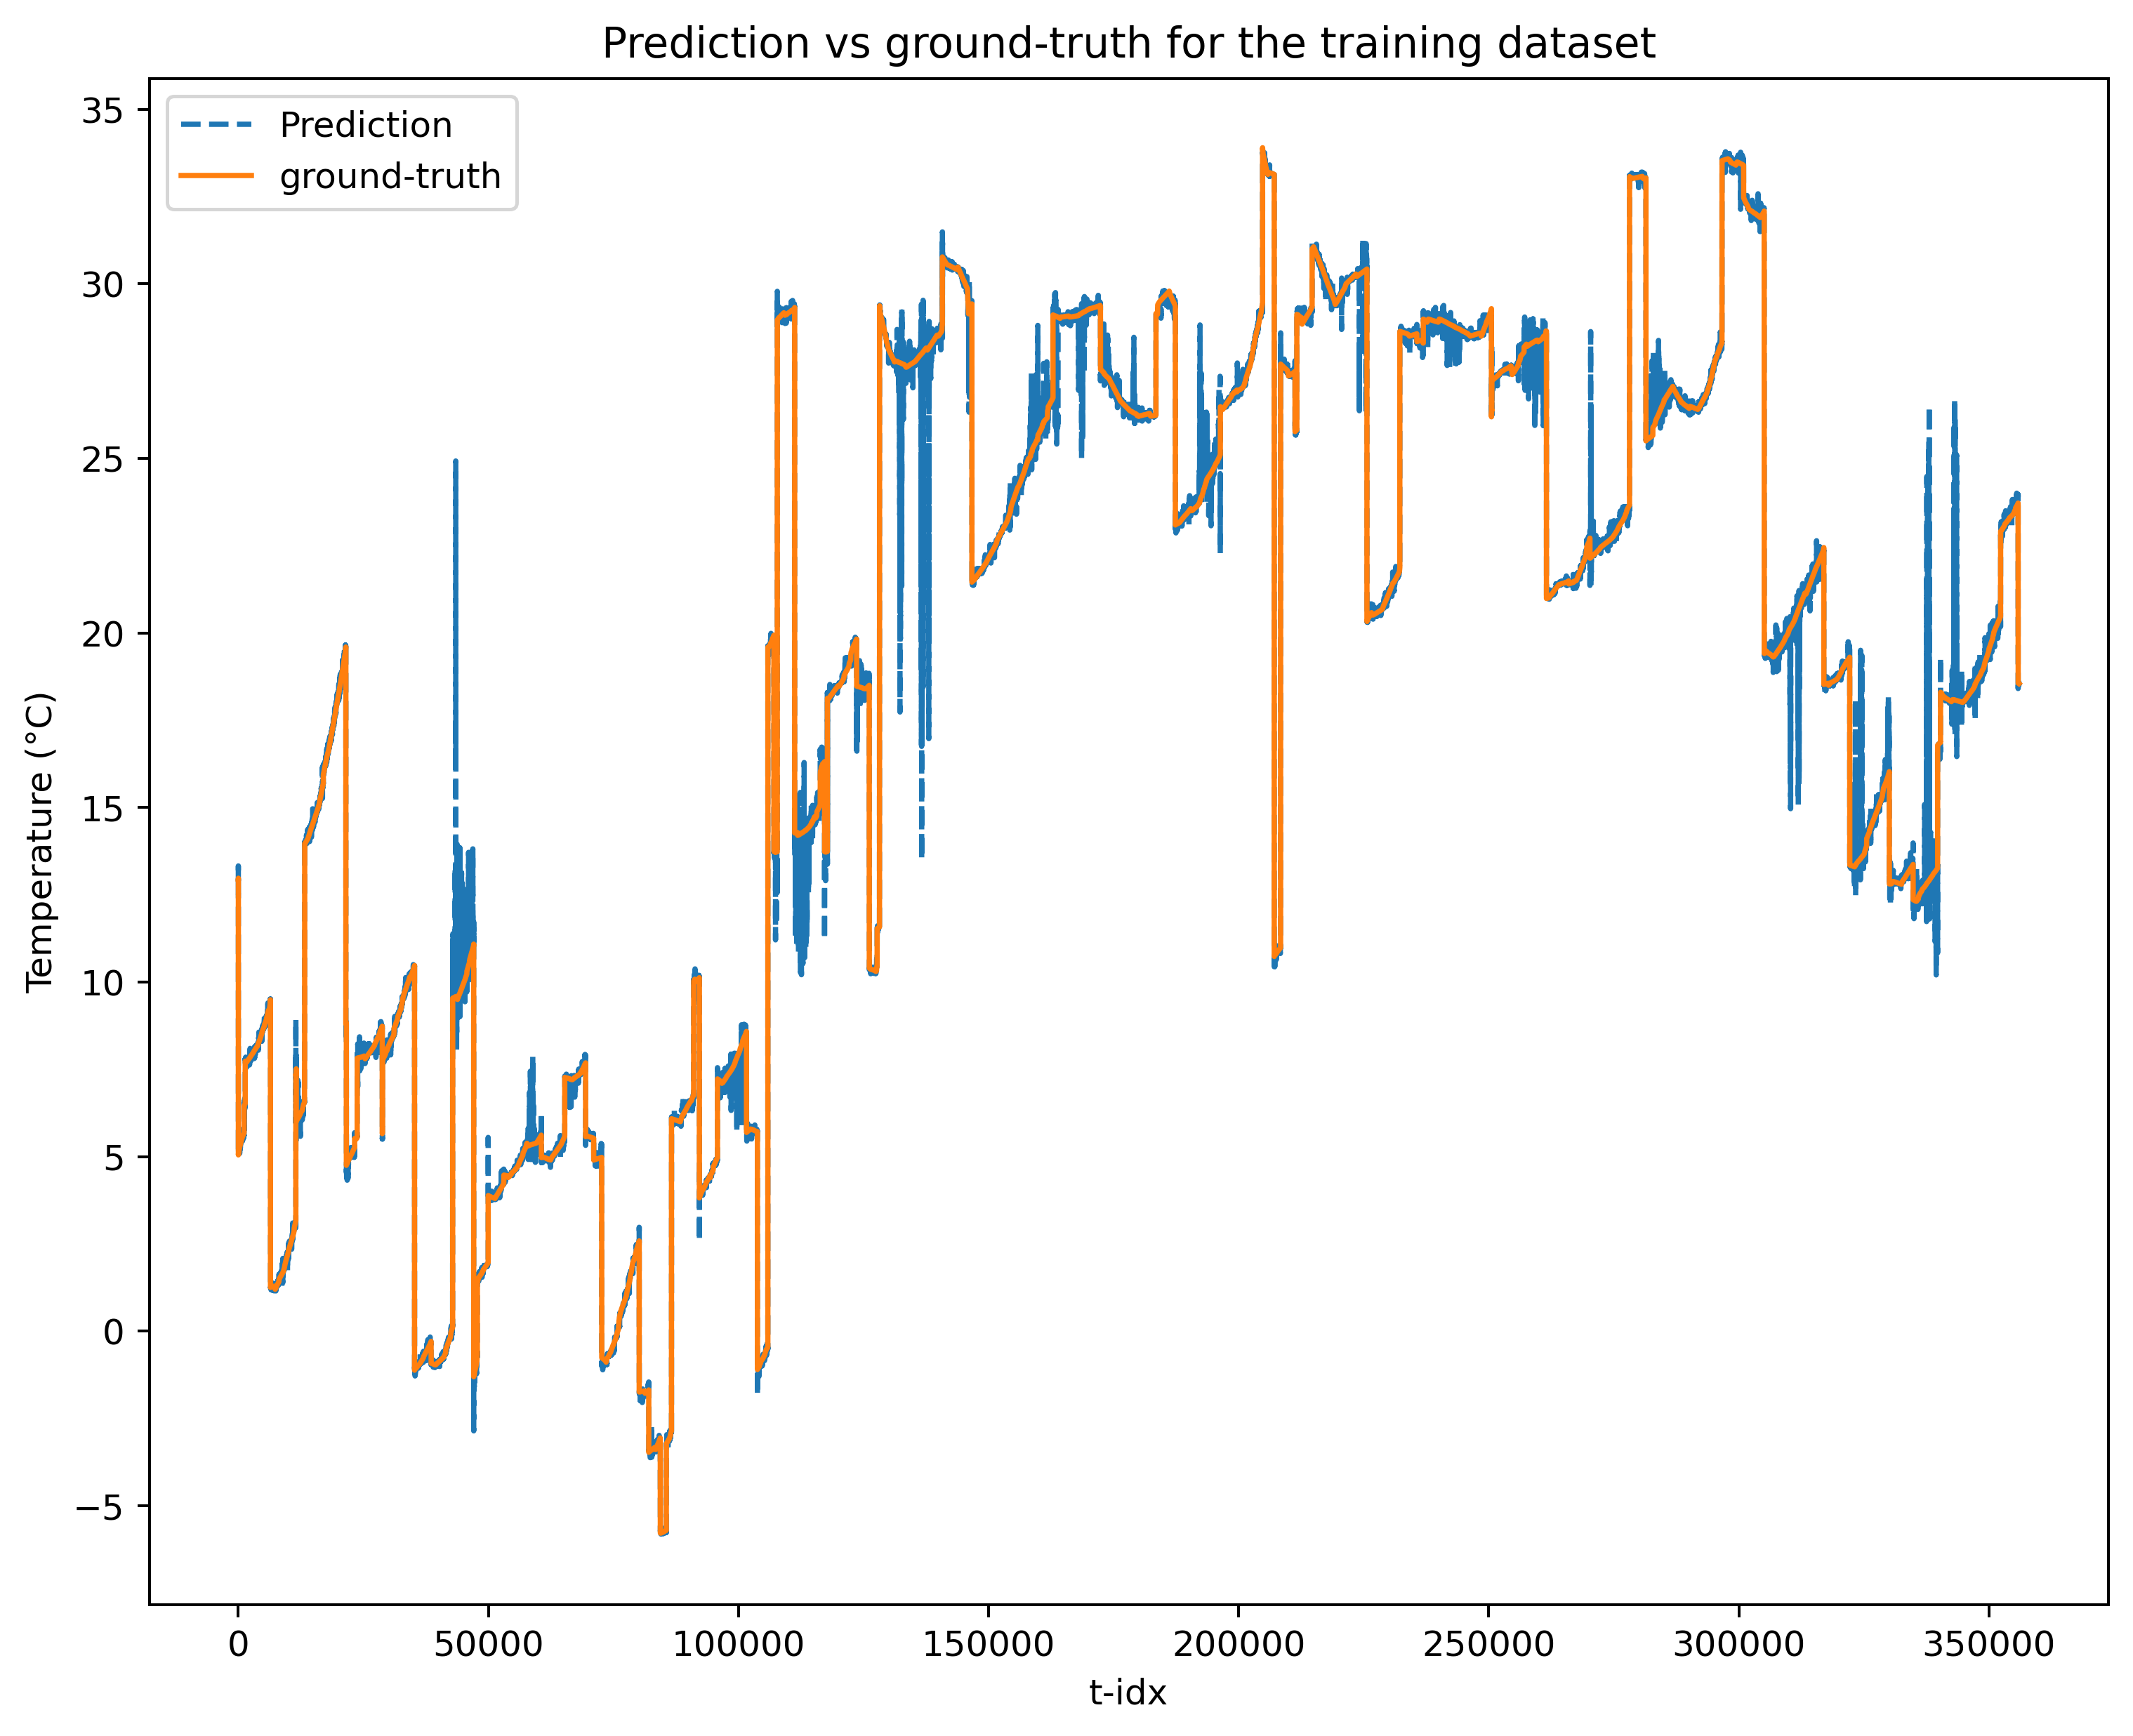

In [14]:
# Make a prediction on trained data
pred = model(ds.x.float().to(device)) #GPU
pred = pred.detach().cpu().numpy()

# ground-truth temperature
gt = ds.y.numpy()

# Some statistics on the model performance on training dataset
mae = np.sum(np.abs(pred - gt).mean(axis=None))
print('MAE:', mae)

mse = ((gt - pred)**2).mean(axis=None)
print('MSE:', mse)

rel_error = np.linalg.norm(pred - gt) / np.linalg.norm(gt)
print('Relative error (%):', rel_error*100)

# Plot of the prediction vs ground-truth
figure(figsize=(10, 8), dpi= 360)
plt.plot(pred, '--')
plt.plot(gt, '-')
plt.title('Prediction vs ground-truth for the training dataset')
plt.legend(['Prediction', 'ground-truth'])
plt.xlabel('t-idx')
plt.ylabel('Temperature (°C)')
plt.show()


## Function for evaluating the model on test data


In [15]:
# Function for evaluating the model's performance on selected test data
def predict(id):
    # Test dataset
    ds_test = TeslaDatasetMlp(device = device, ID = id, data = "test")

    # time
    t = ds_test.t

    # prediction
    pred = model(ds_test.x.float().to(device)) #GPU
    pred = pred.detach().cpu().numpy()

    # ground-truth
    gt = ds_test.y.numpy()

    # Some statistics on the model performance on test dataset
    mae = np.sum(np.abs(pred - gt).mean(axis=None))
    print('MAE:', mae)

    mse = ((gt - pred)**2).mean(axis=None)
    print('MSE:', mse)

    rel_error = np.linalg.norm(pred - gt) / np.linalg.norm(gt)
    print('Relative error (%):', rel_error*100)

    # # 
    # figure(figsize=(10, 8), dpi= 360)
    # plt.plot(pred, '--')
    # plt.plot(gt, '-')
    # plt.title('Prediction vs ground-truth for drive-id = {}'.format(id))
    # plt.legend(['Prediction', 'ground-truth'])
    # plt.xlabel('t-idx')
    # plt.ylabel('Temperature (°C)')
    # plt.show()
    
    # Plot of the prediction vs ground-truth
    figure(figsize=(10, 8), dpi= 360)
    plt.plot(t,pred, '--')
    plt.plot(t,gt, '-')
    plt.title('Prediction vs ground-truth for drive-id = {}'.format(id))
    plt.legend(['Prediction', 'ground-truth'])
    plt.xlabel('t (seconds)')
    plt.ylabel('Temperature (°C)')
    plt.show()
    return mae,mse,rel_error

3. Performance oof the model on test data

MAE: 1.6180475
MSE: 6.427519
Relative error (%): 54.62280511856079


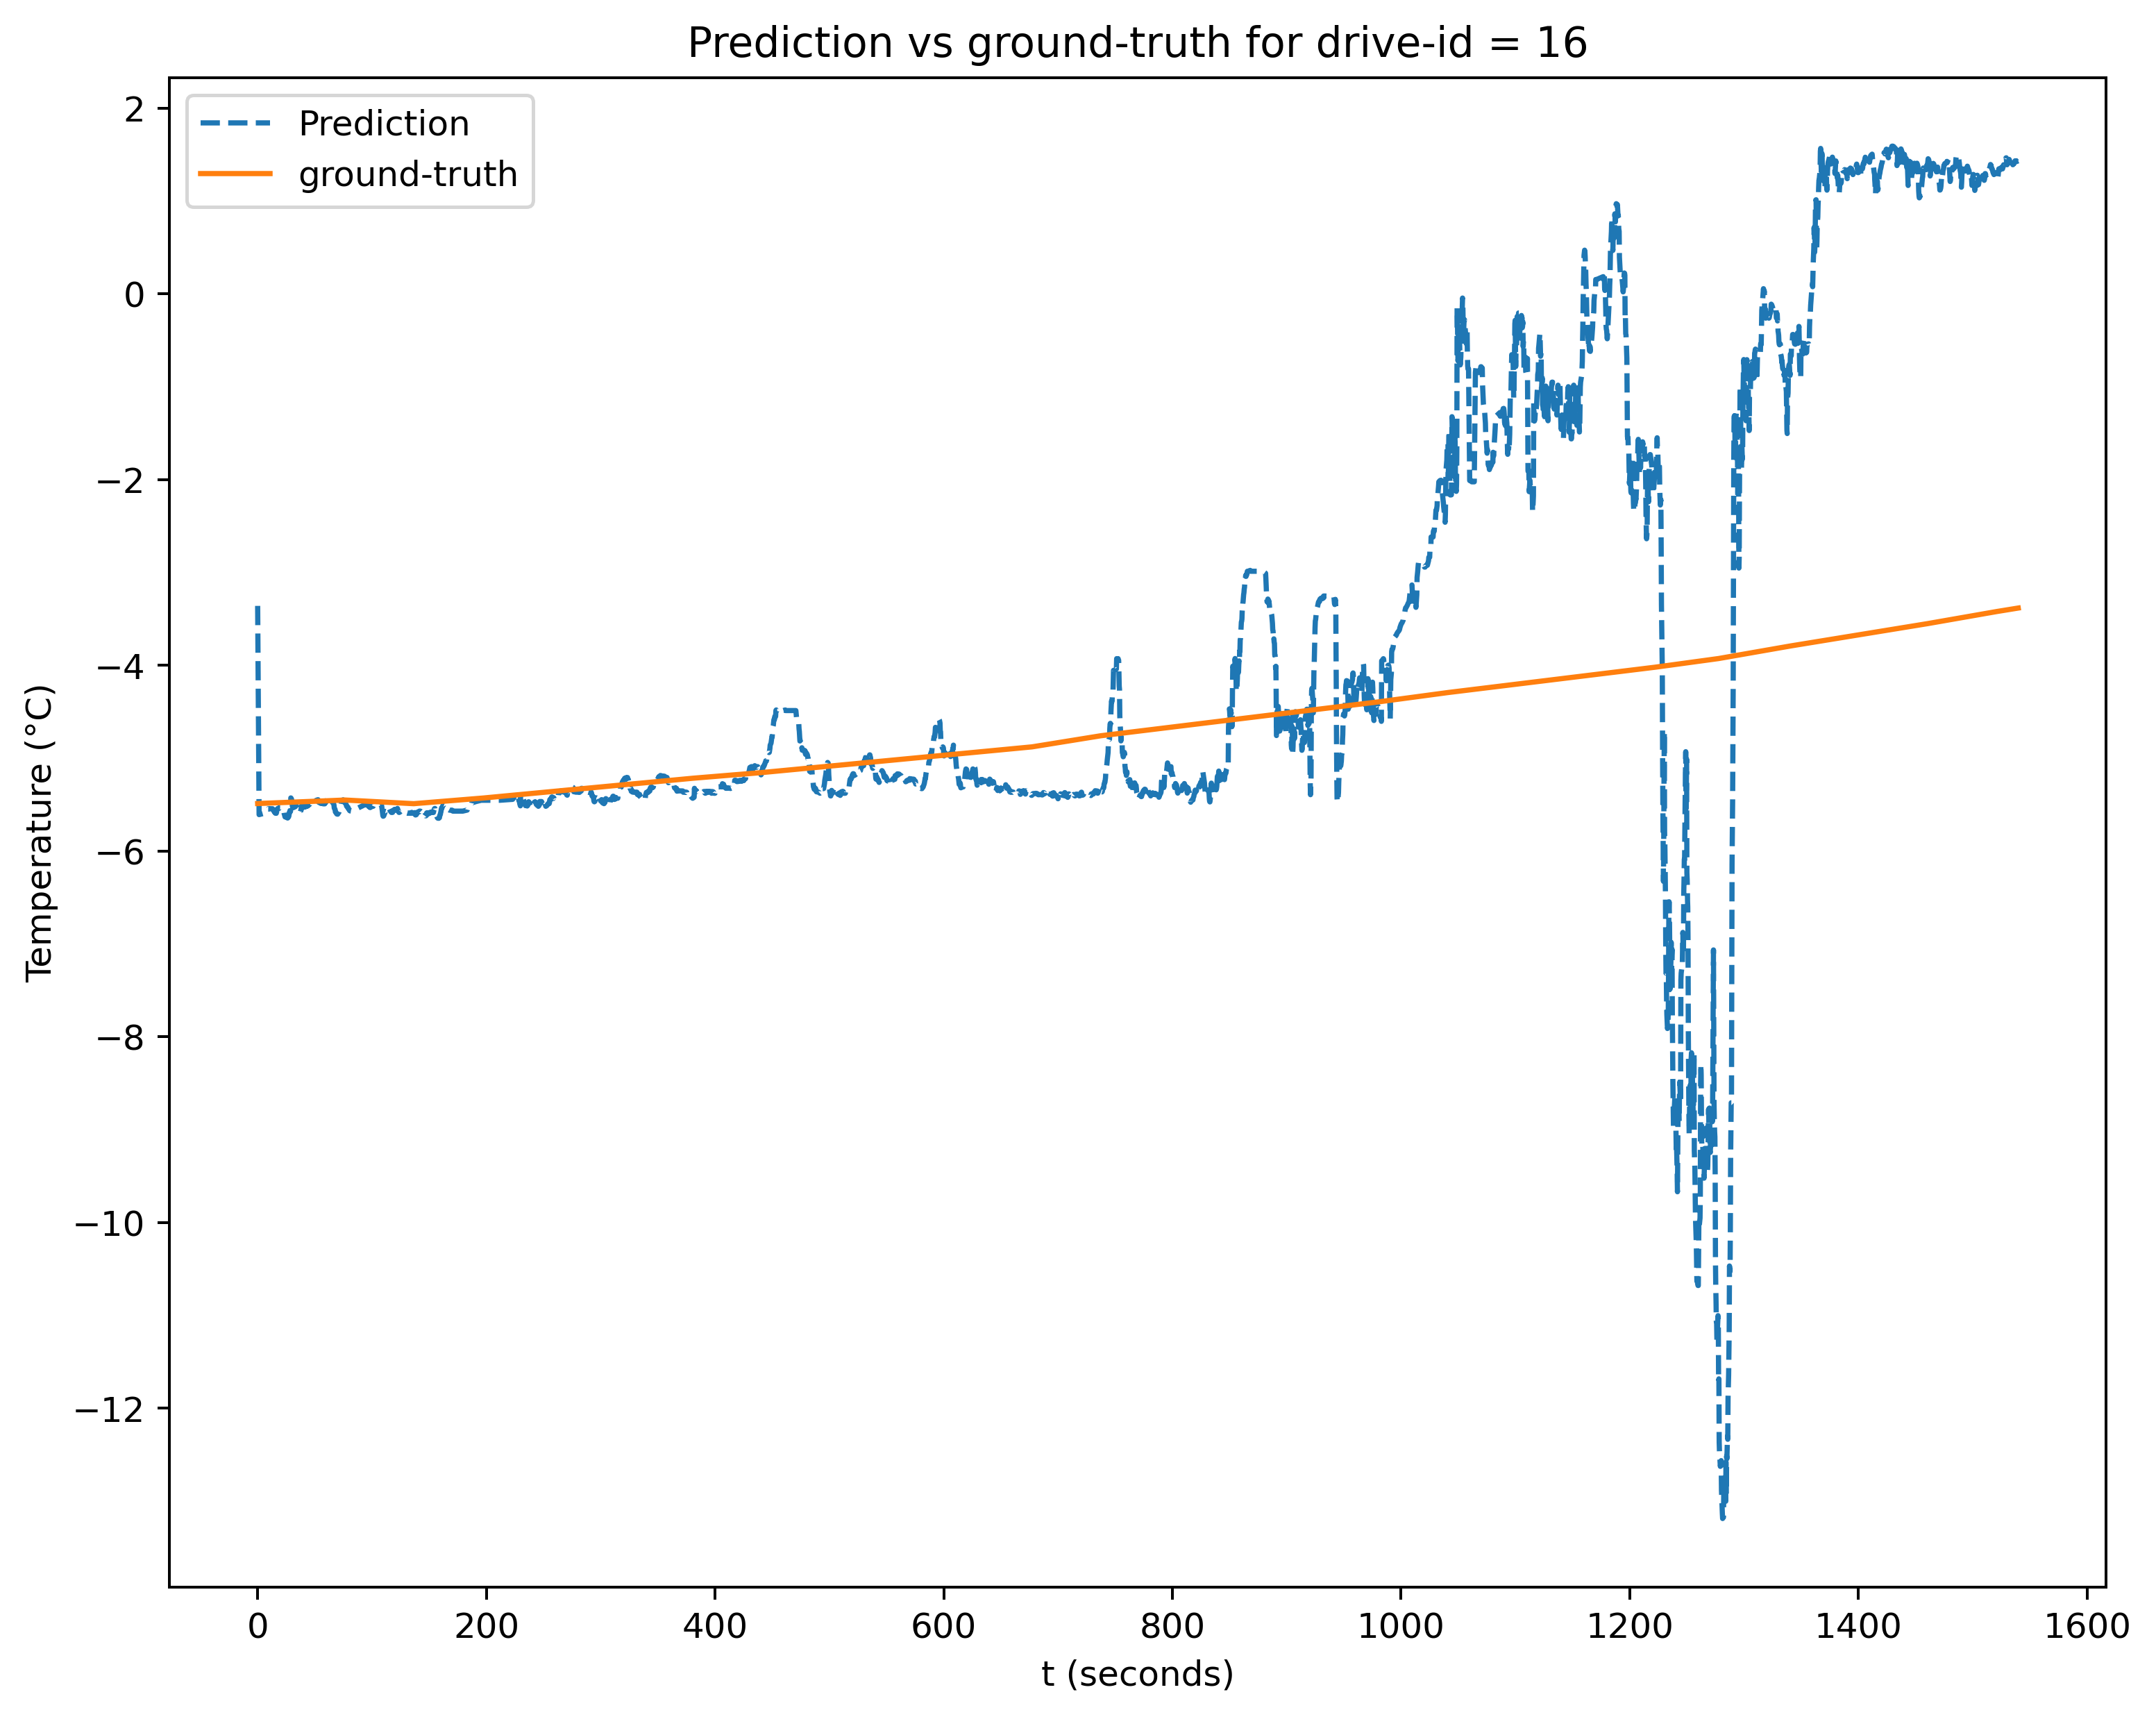

In [16]:
# Test values = [16,39,47,52,72,81,88]

mae16,mse16,rel_error16 = predict(16)

MAE: 3.3860188
MSE: 17.539764
Relative error (%): 18.249766528606415


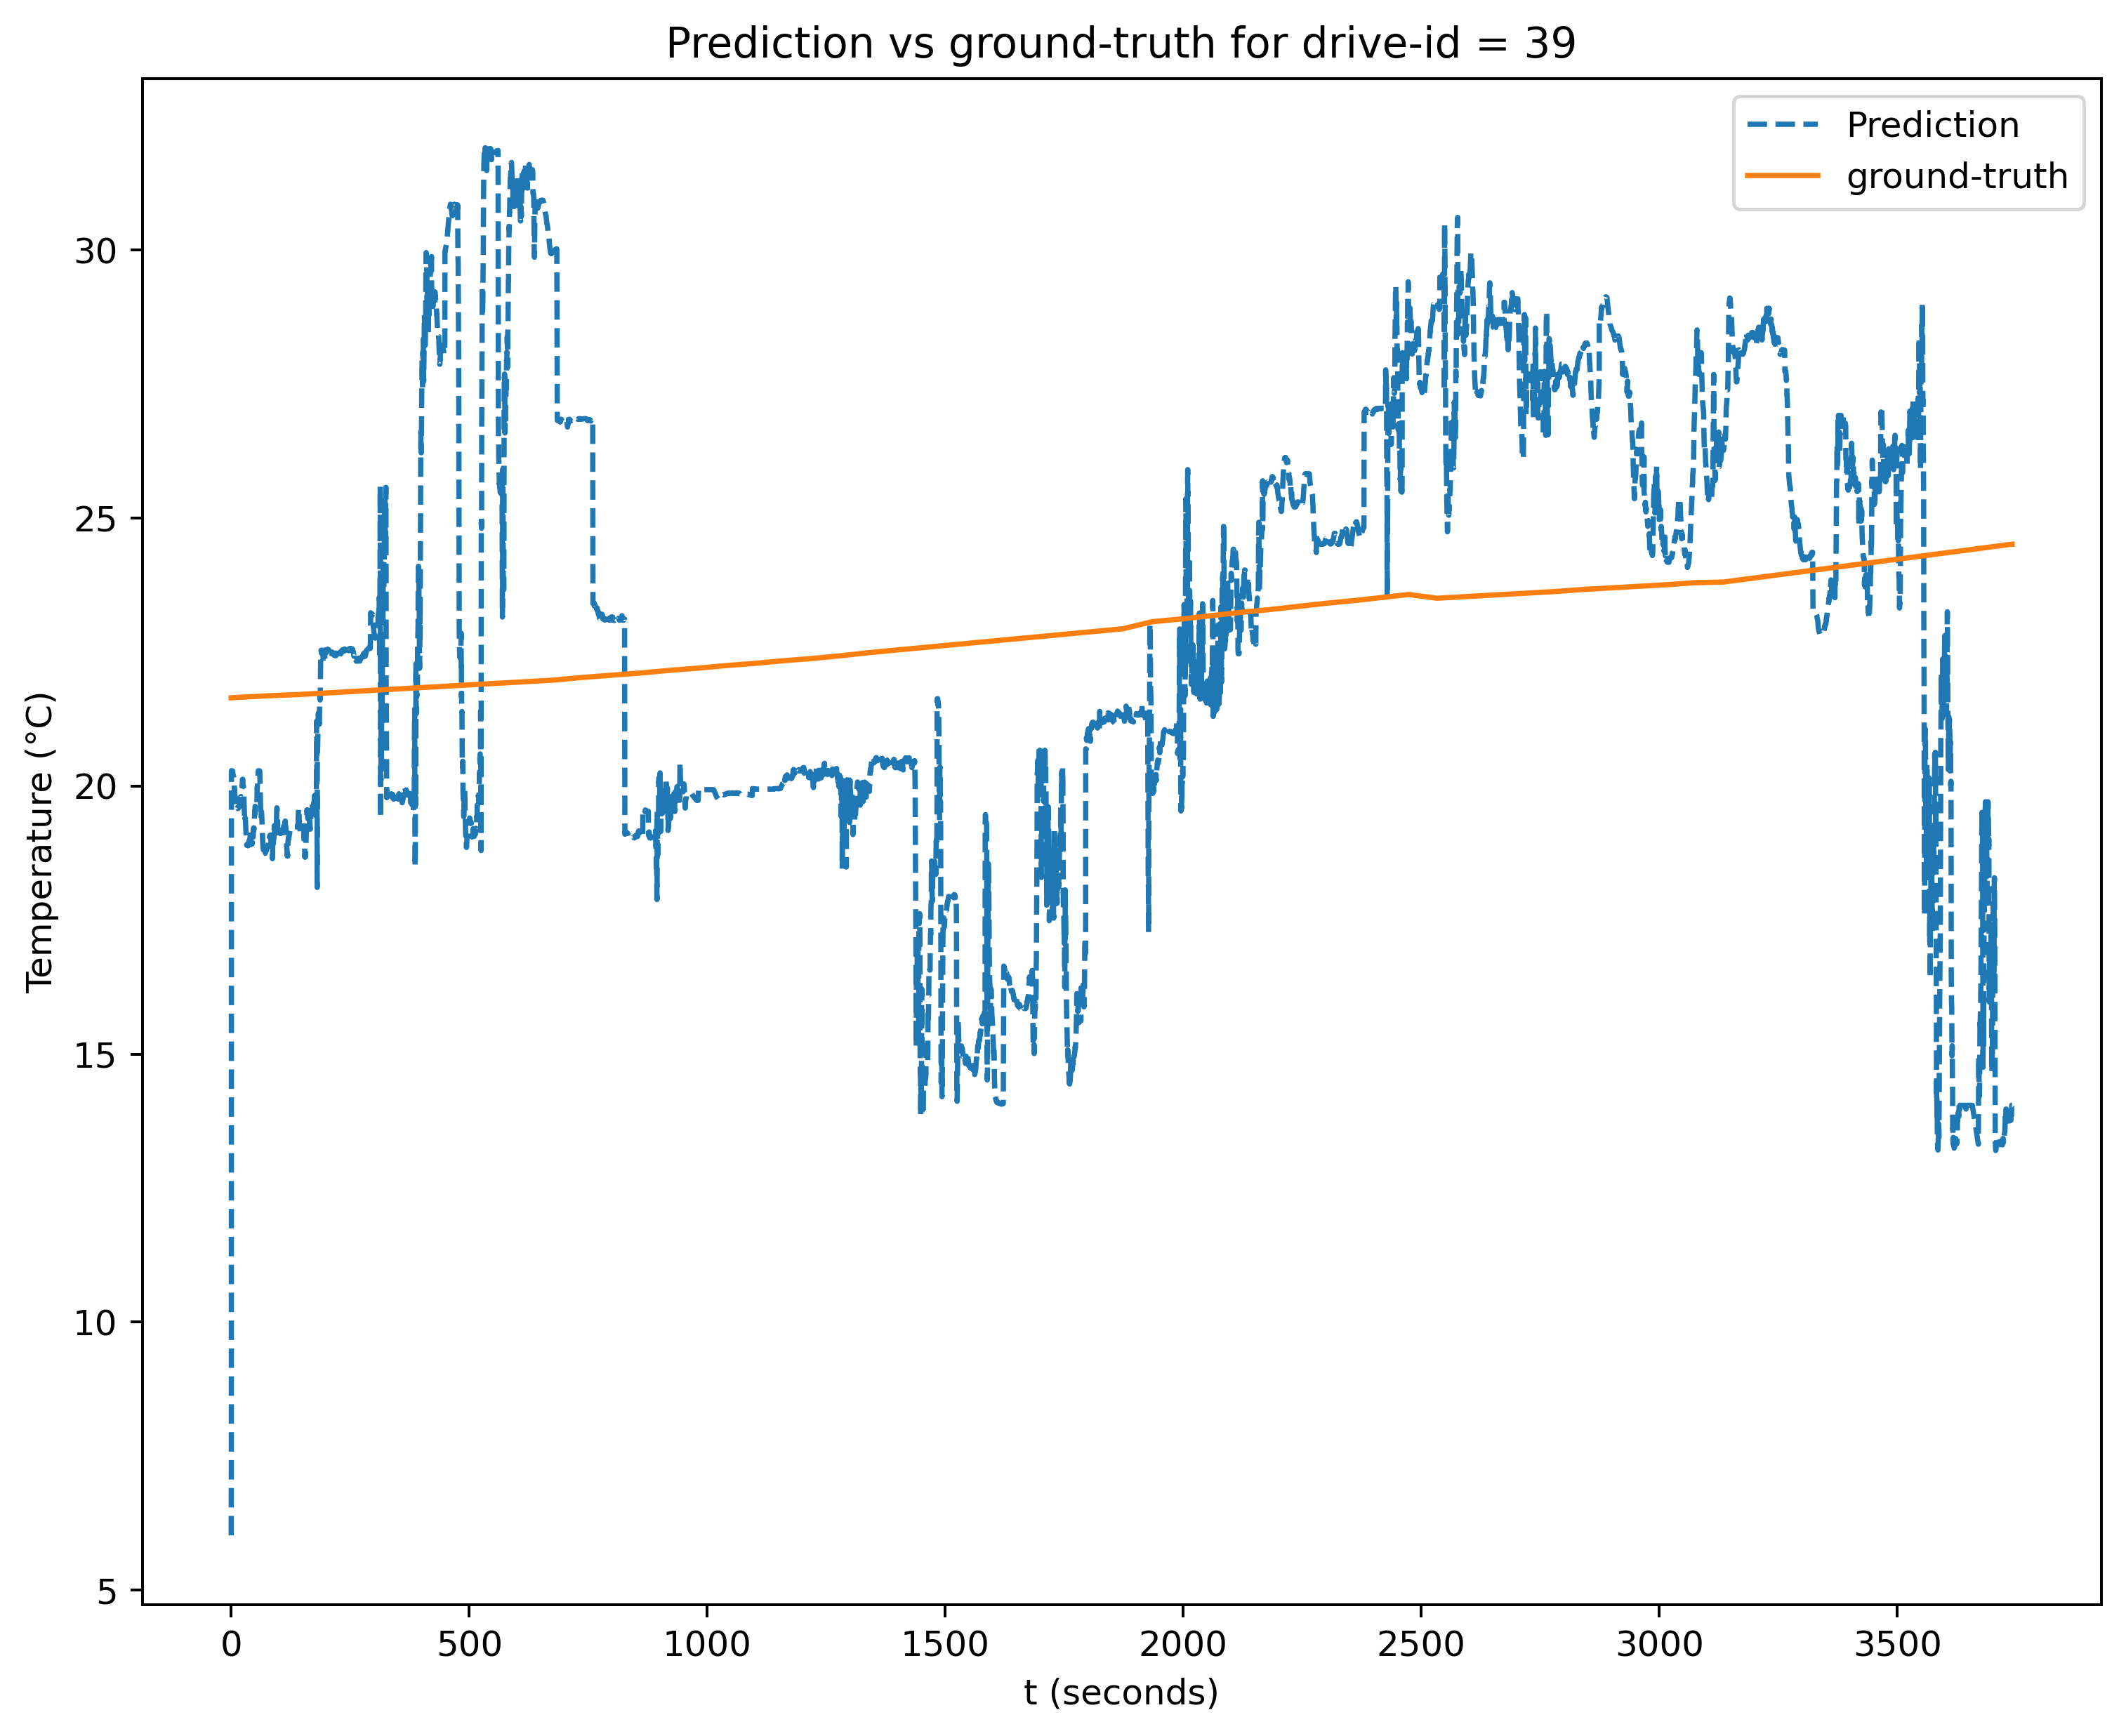

In [17]:
mae39,mse39,rel_error39 = predict(39)

MAE: 6.427469
MSE: 67.02946
Relative error (%): 25.892052054405212


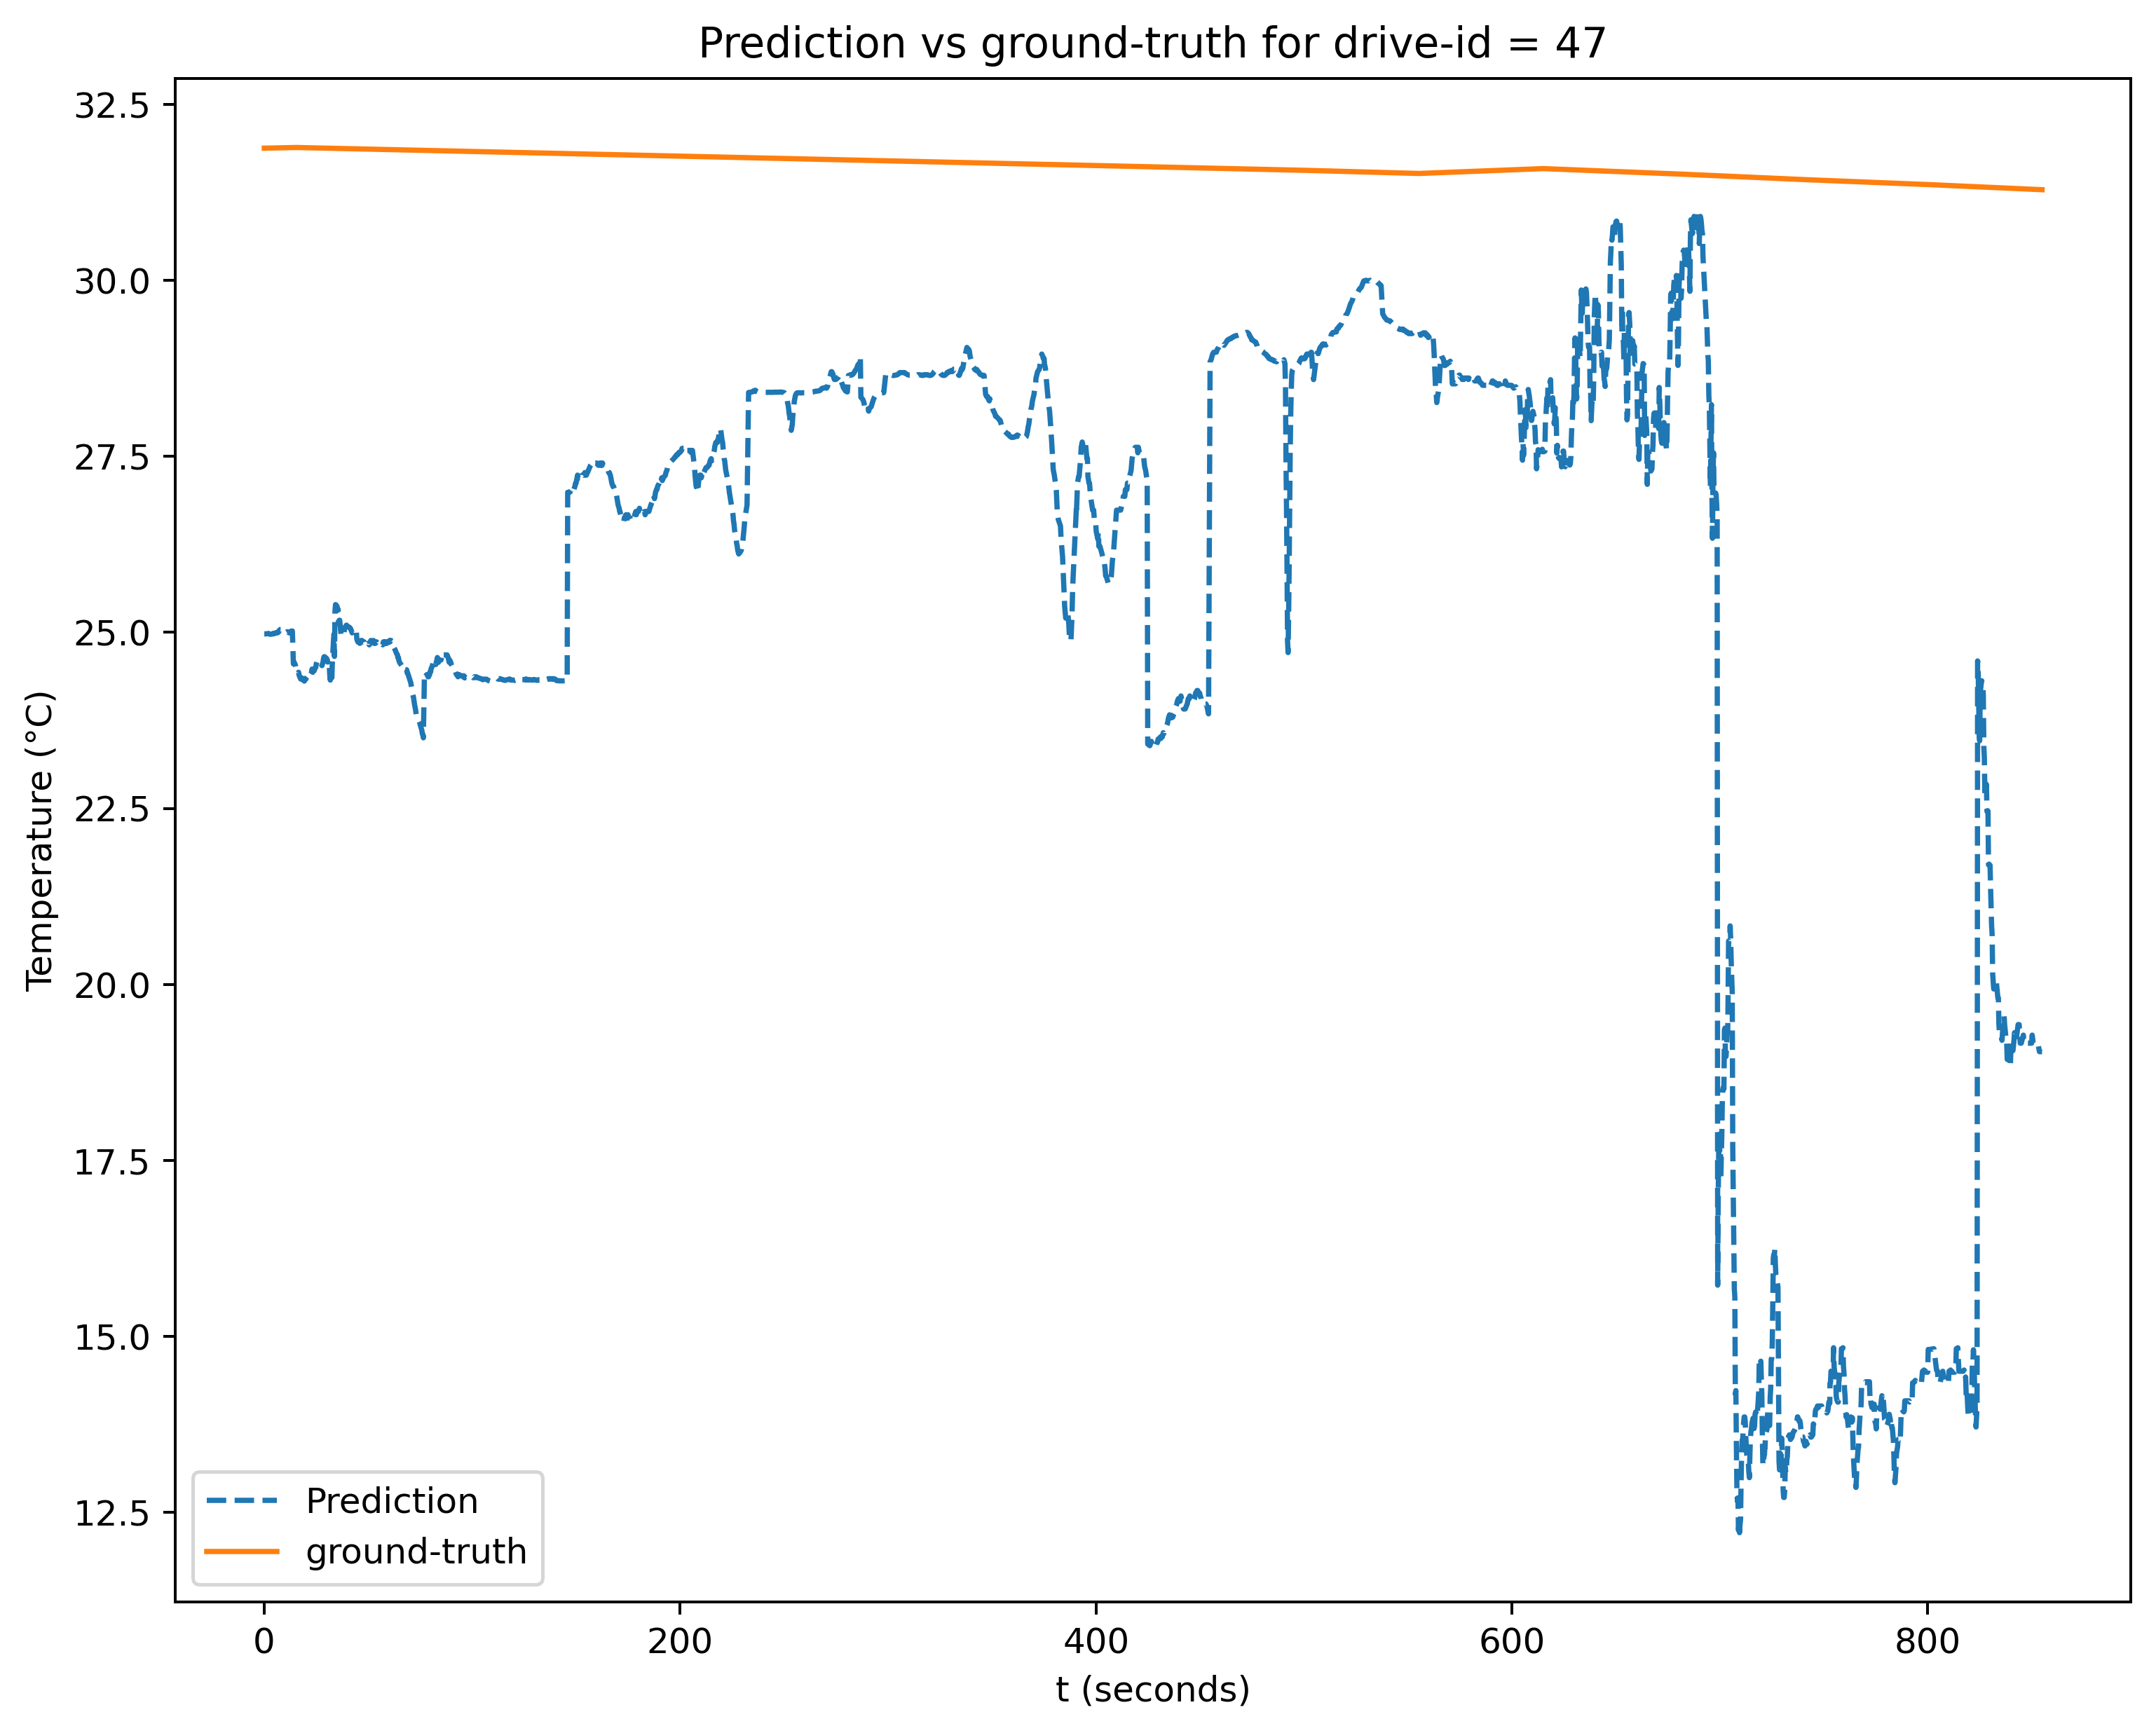

In [18]:
mae47,mse47,rel_error47 = predict(47)

MAE: 1.0334681
MSE: 1.9349586
Relative error (%): 6.697960197925568


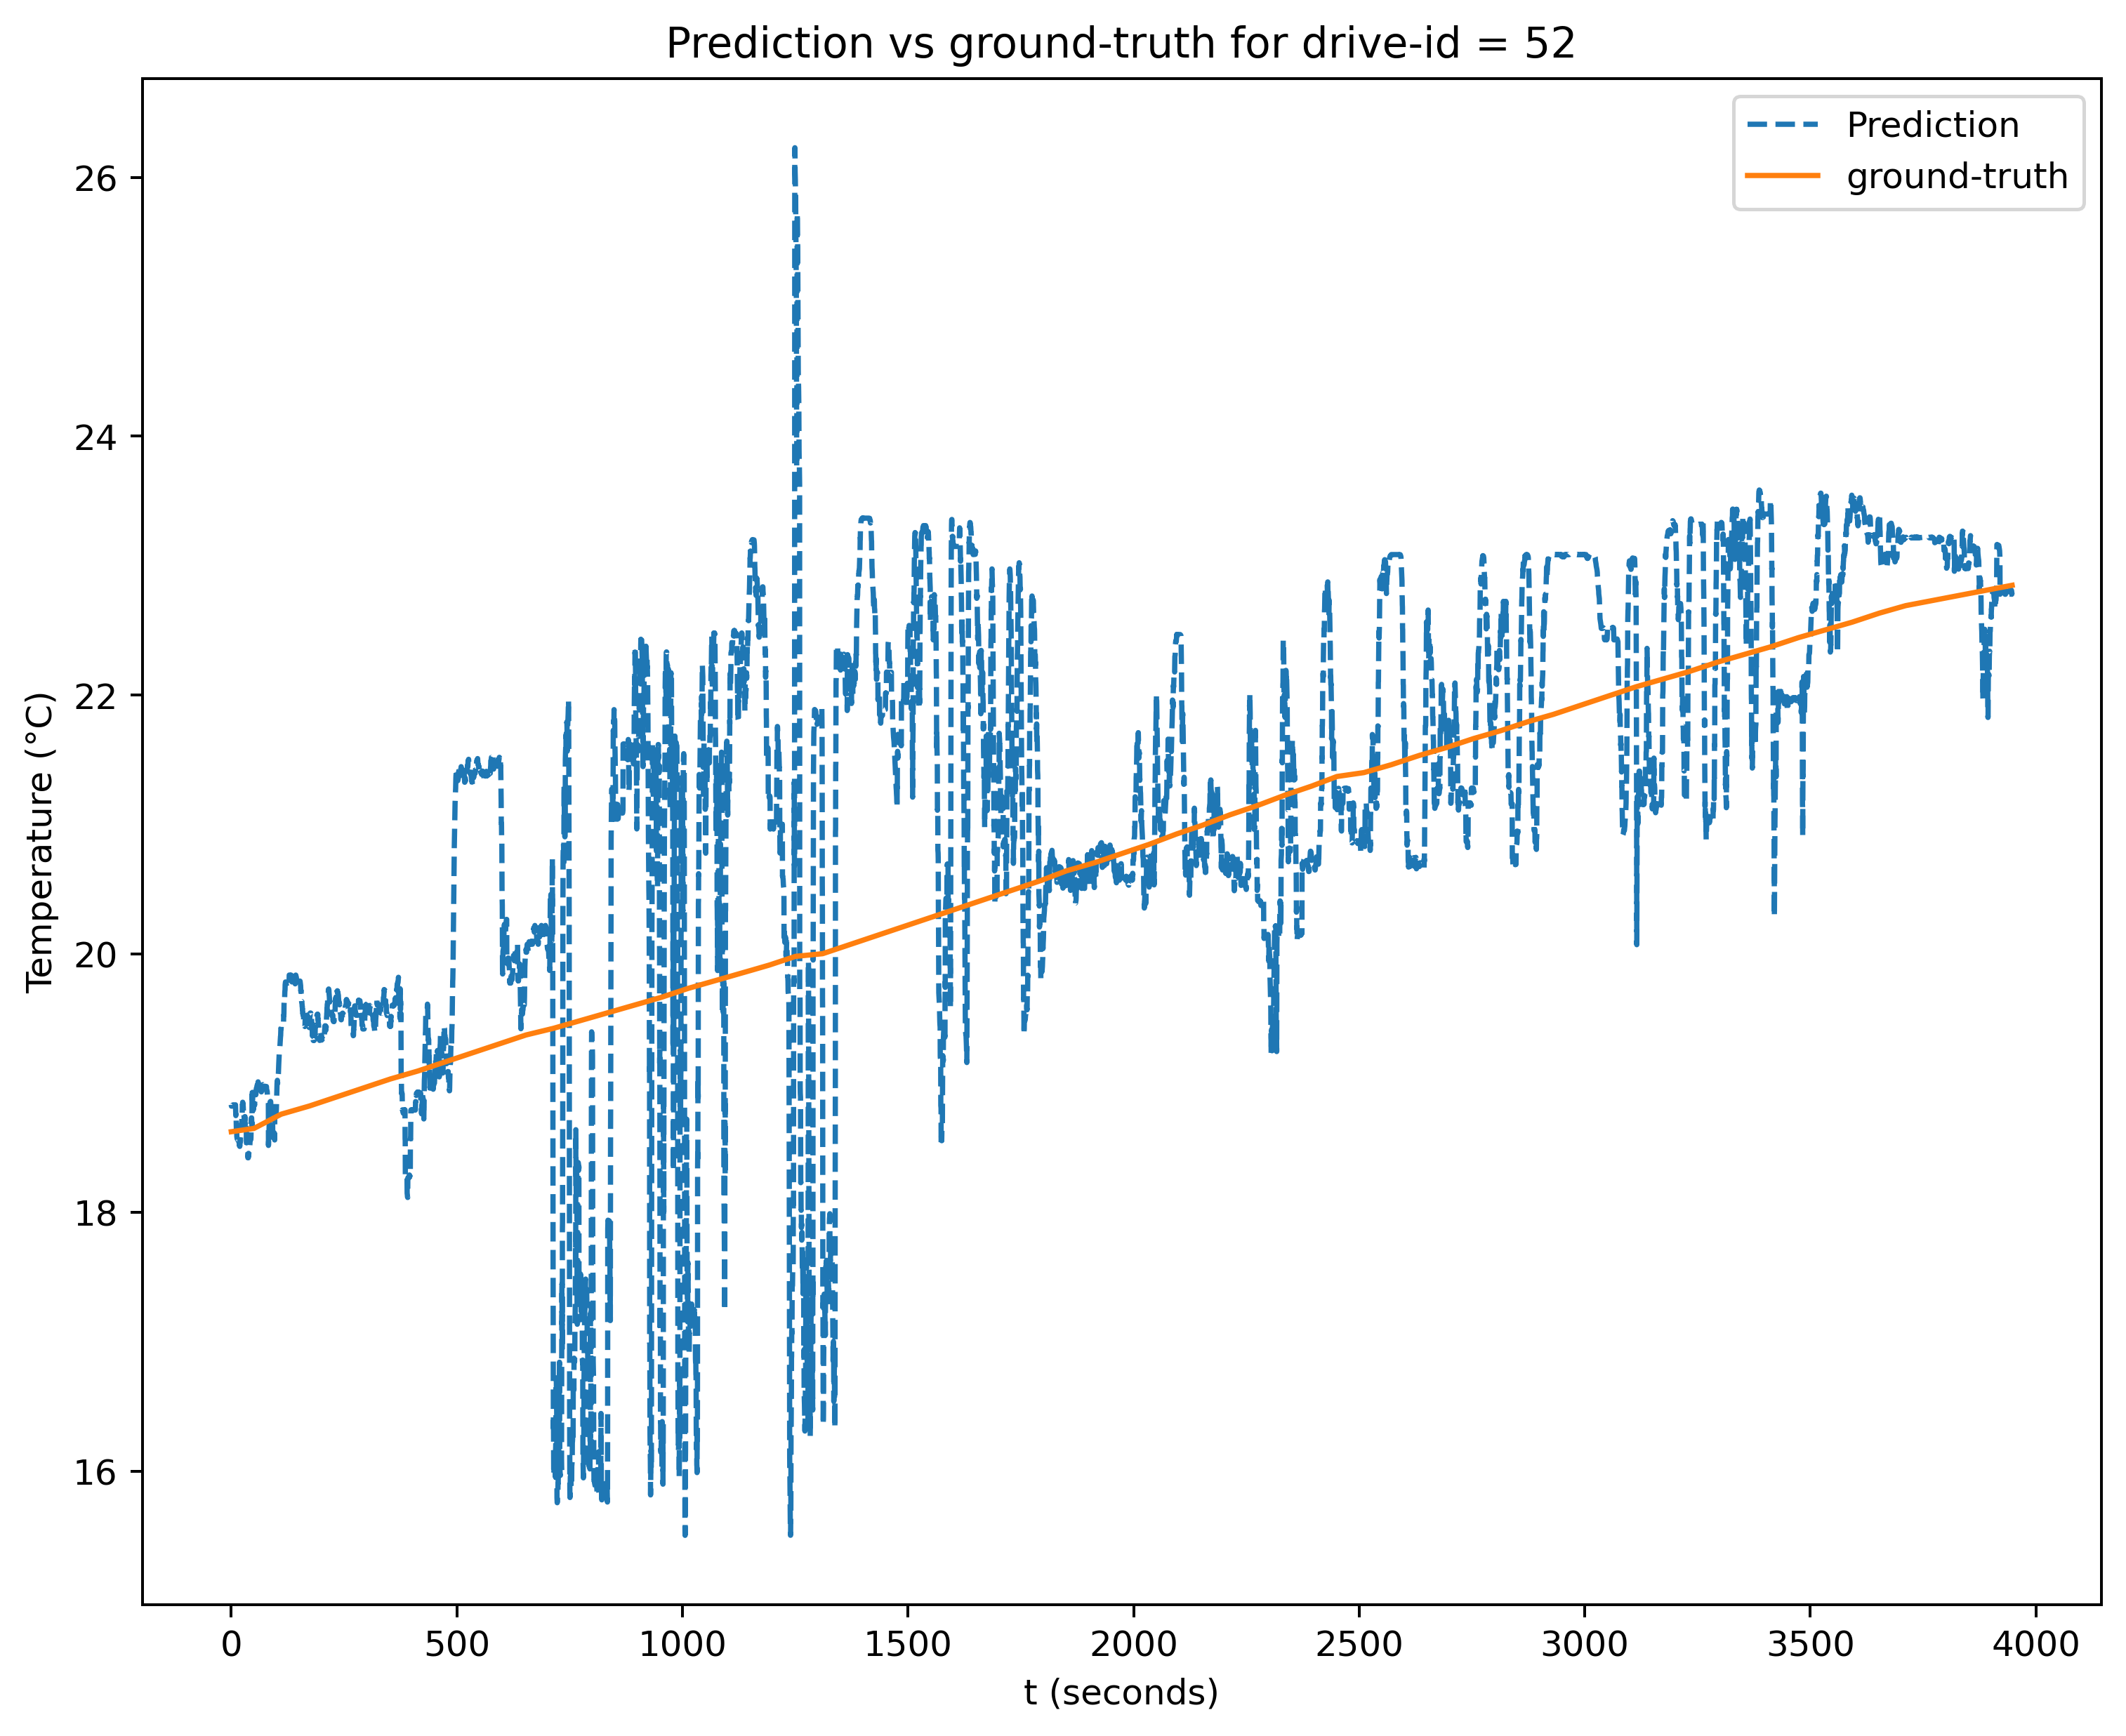

In [19]:
mae52,mse52,rel_error52 = predict(52)

MAE: 9.639071
MSE: 138.22069
Relative error (%): 68.41145753860474


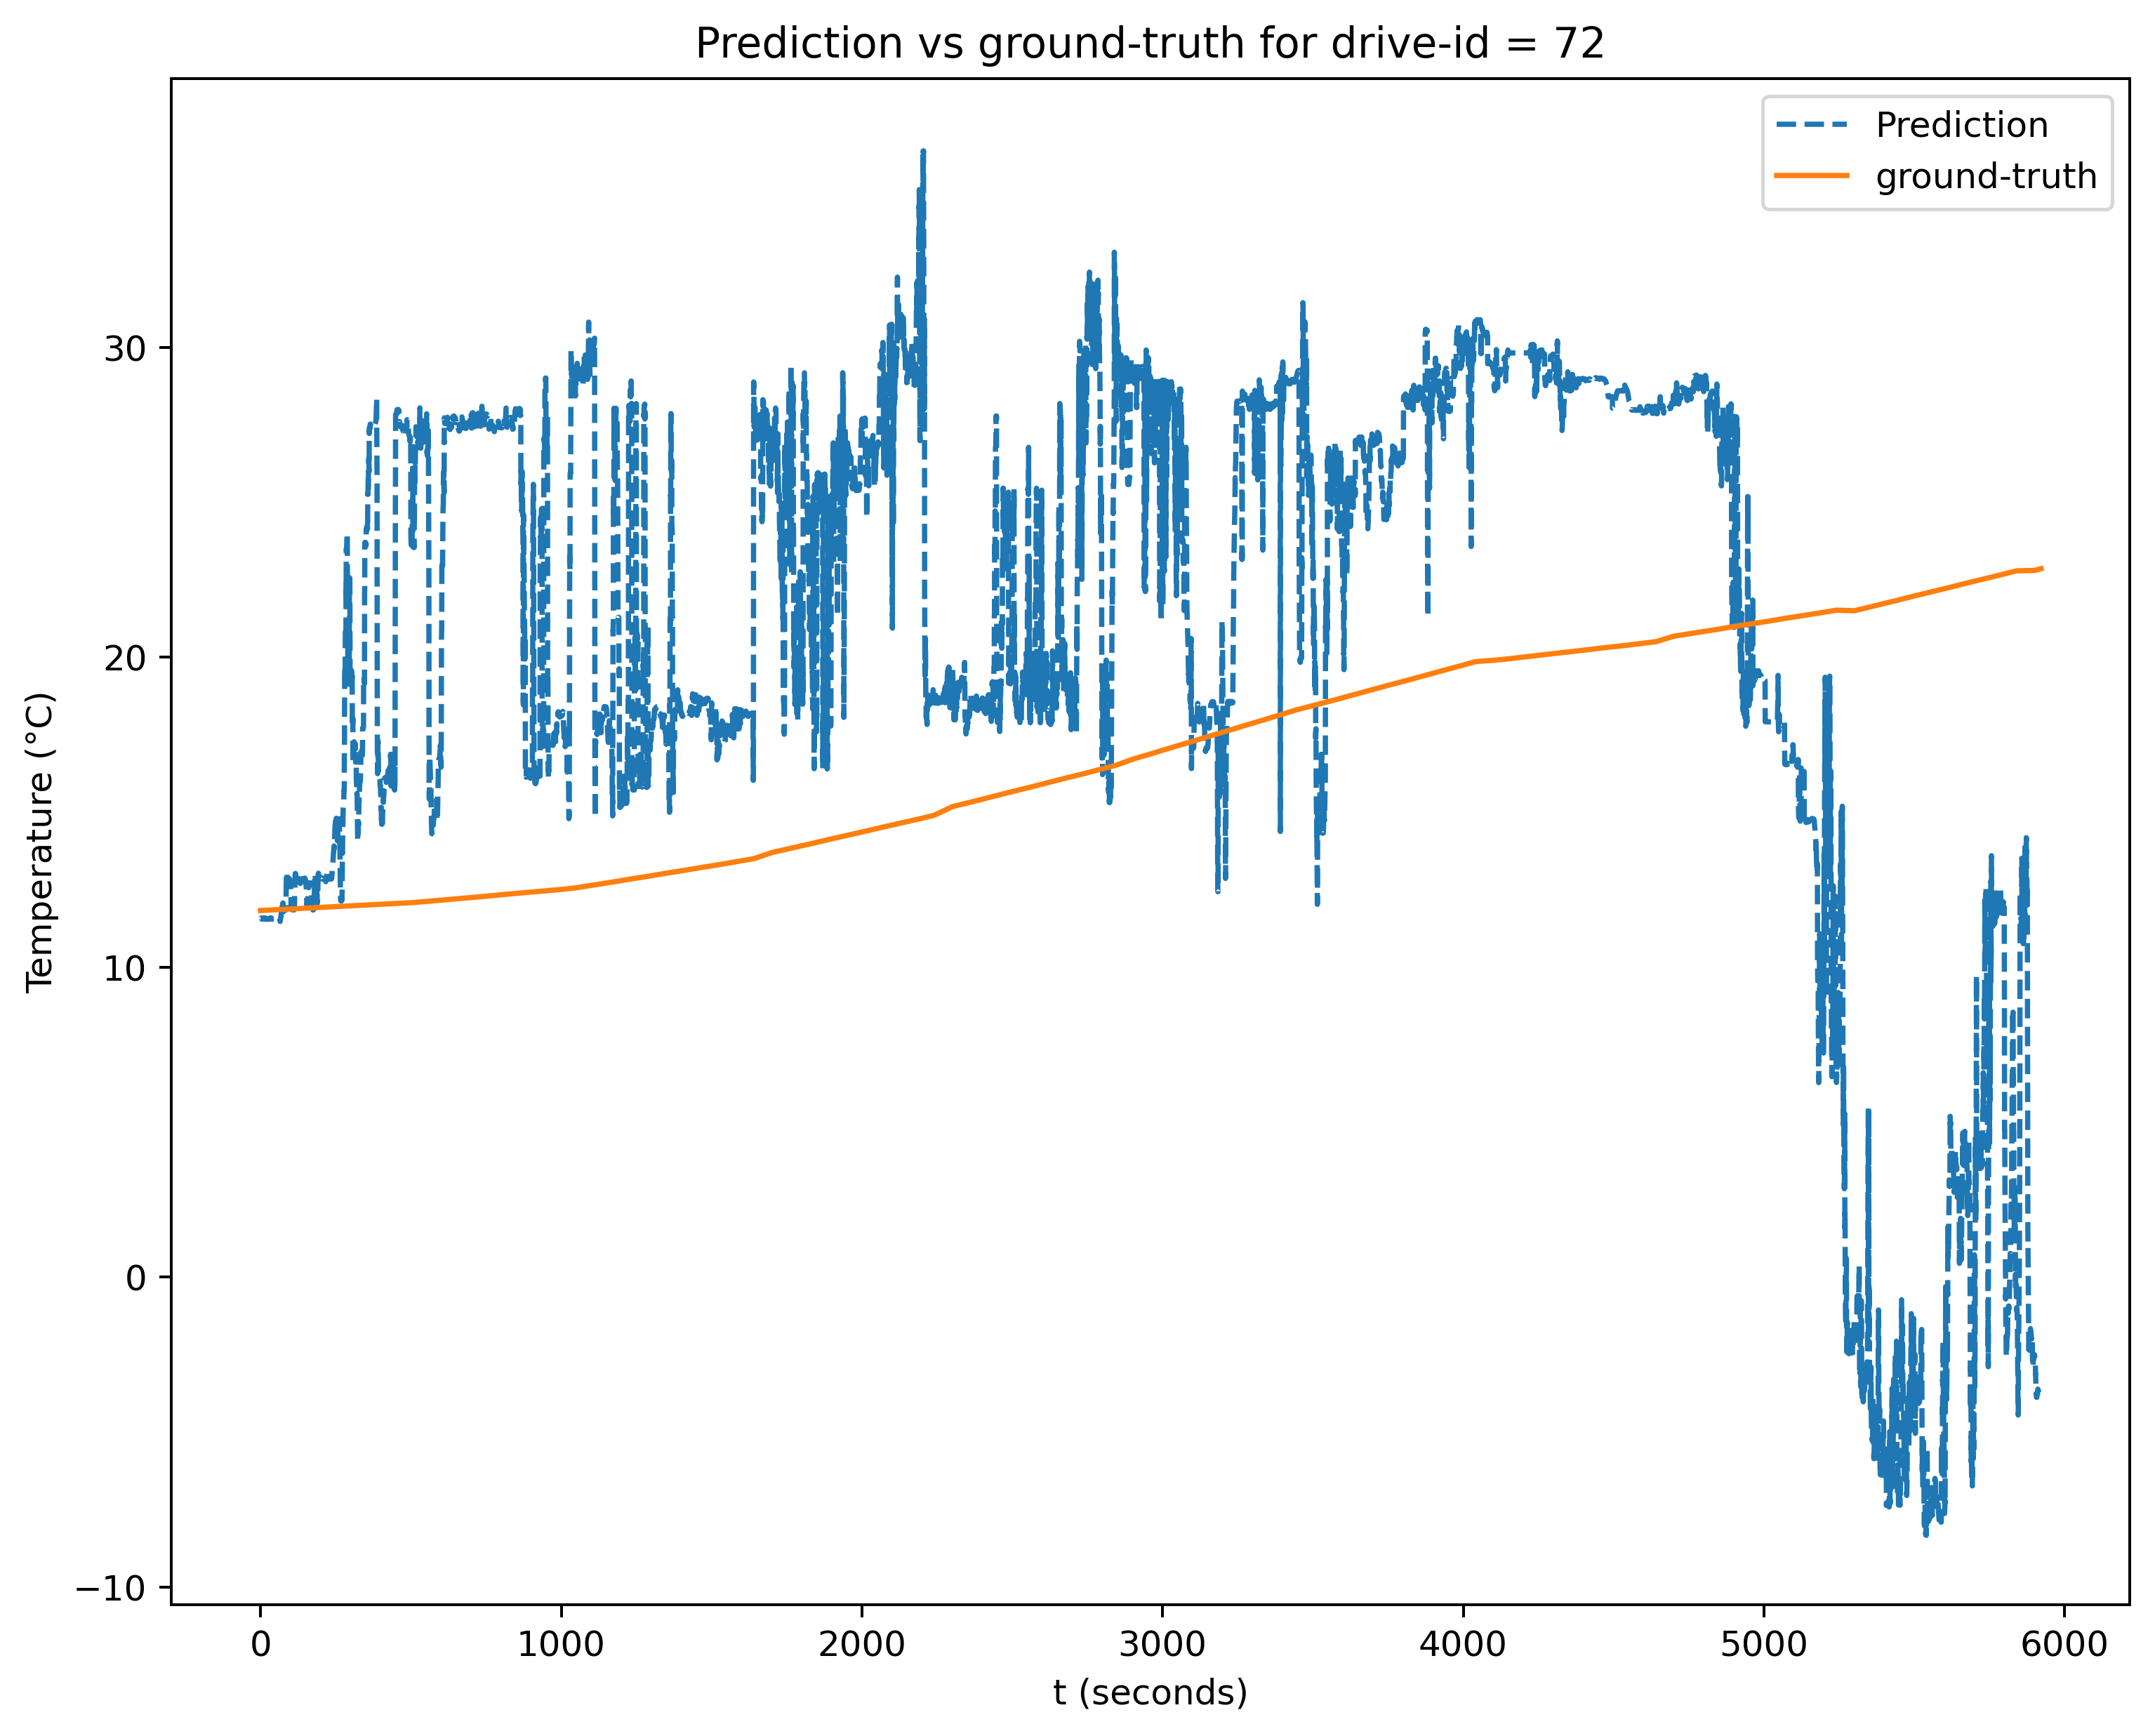

In [20]:
mae72,mse72,rel_error72 = predict(72)

MAE: 1.1412661
MSE: 1.8613645
Relative error (%): 4.748018831014633


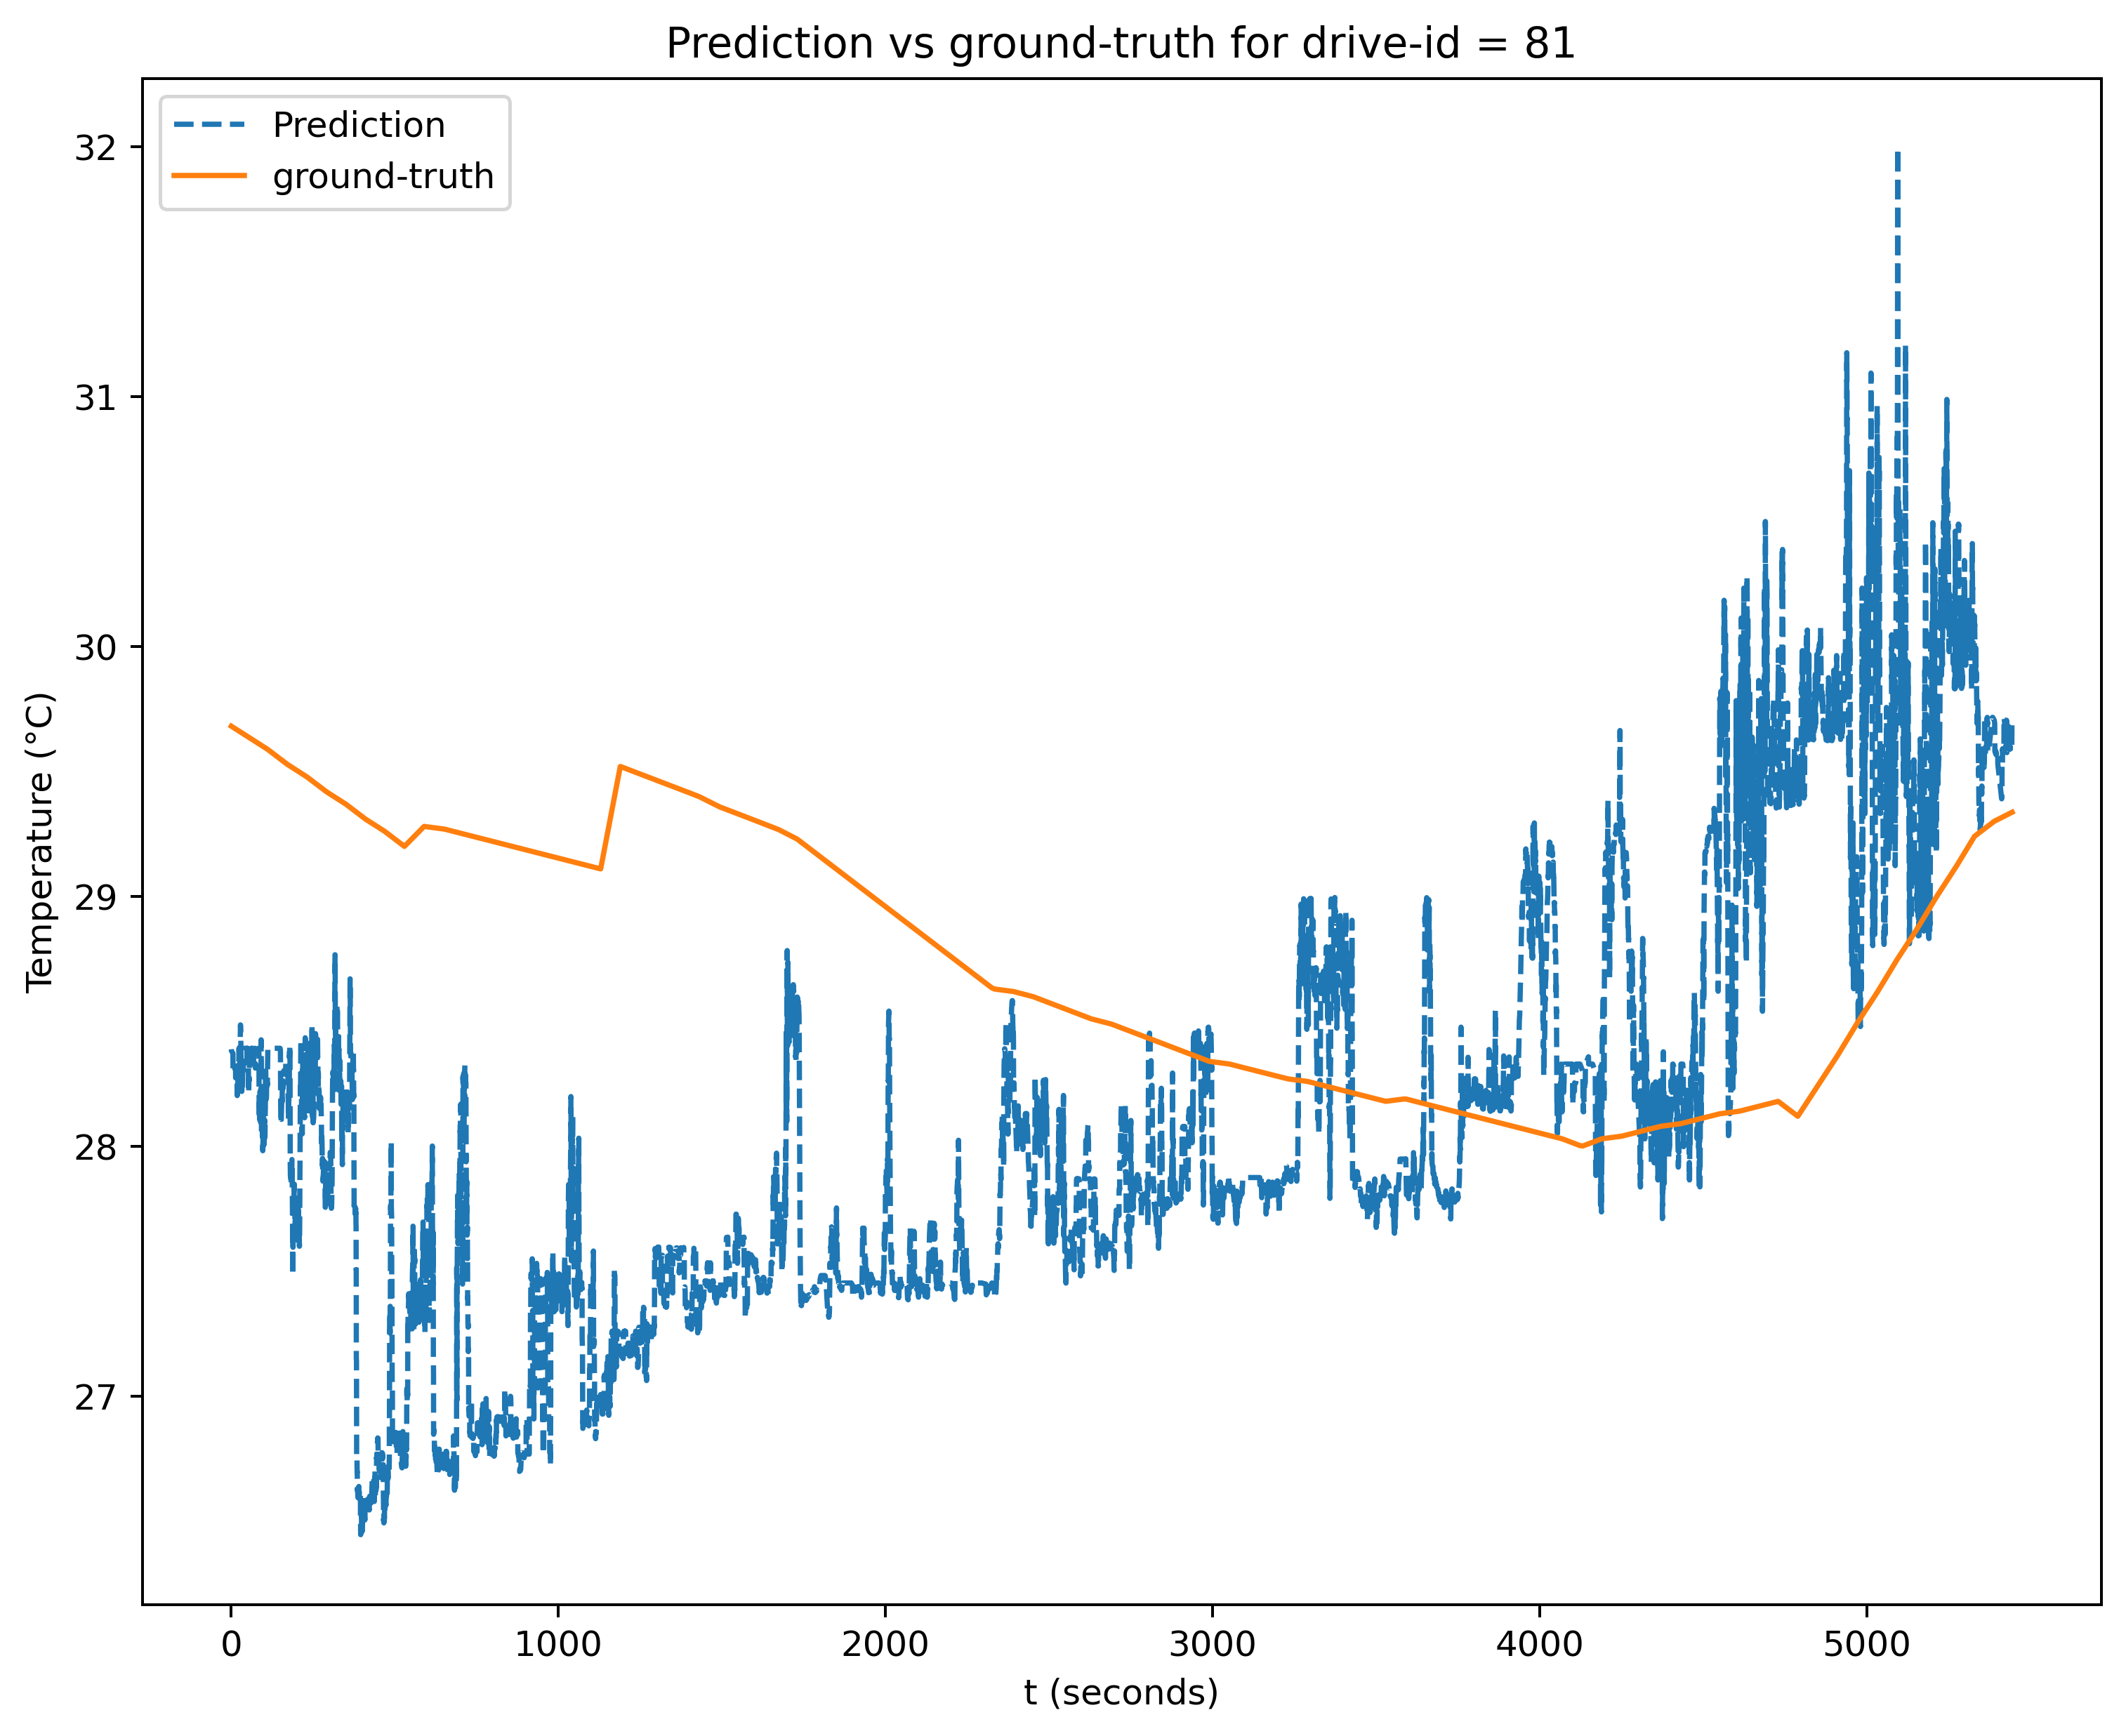

In [21]:
mae81,mse81,rel_error81 = predict(81)

MAE: 6.204208
MSE: 41.503437
Relative error (%): 19.24256980419159


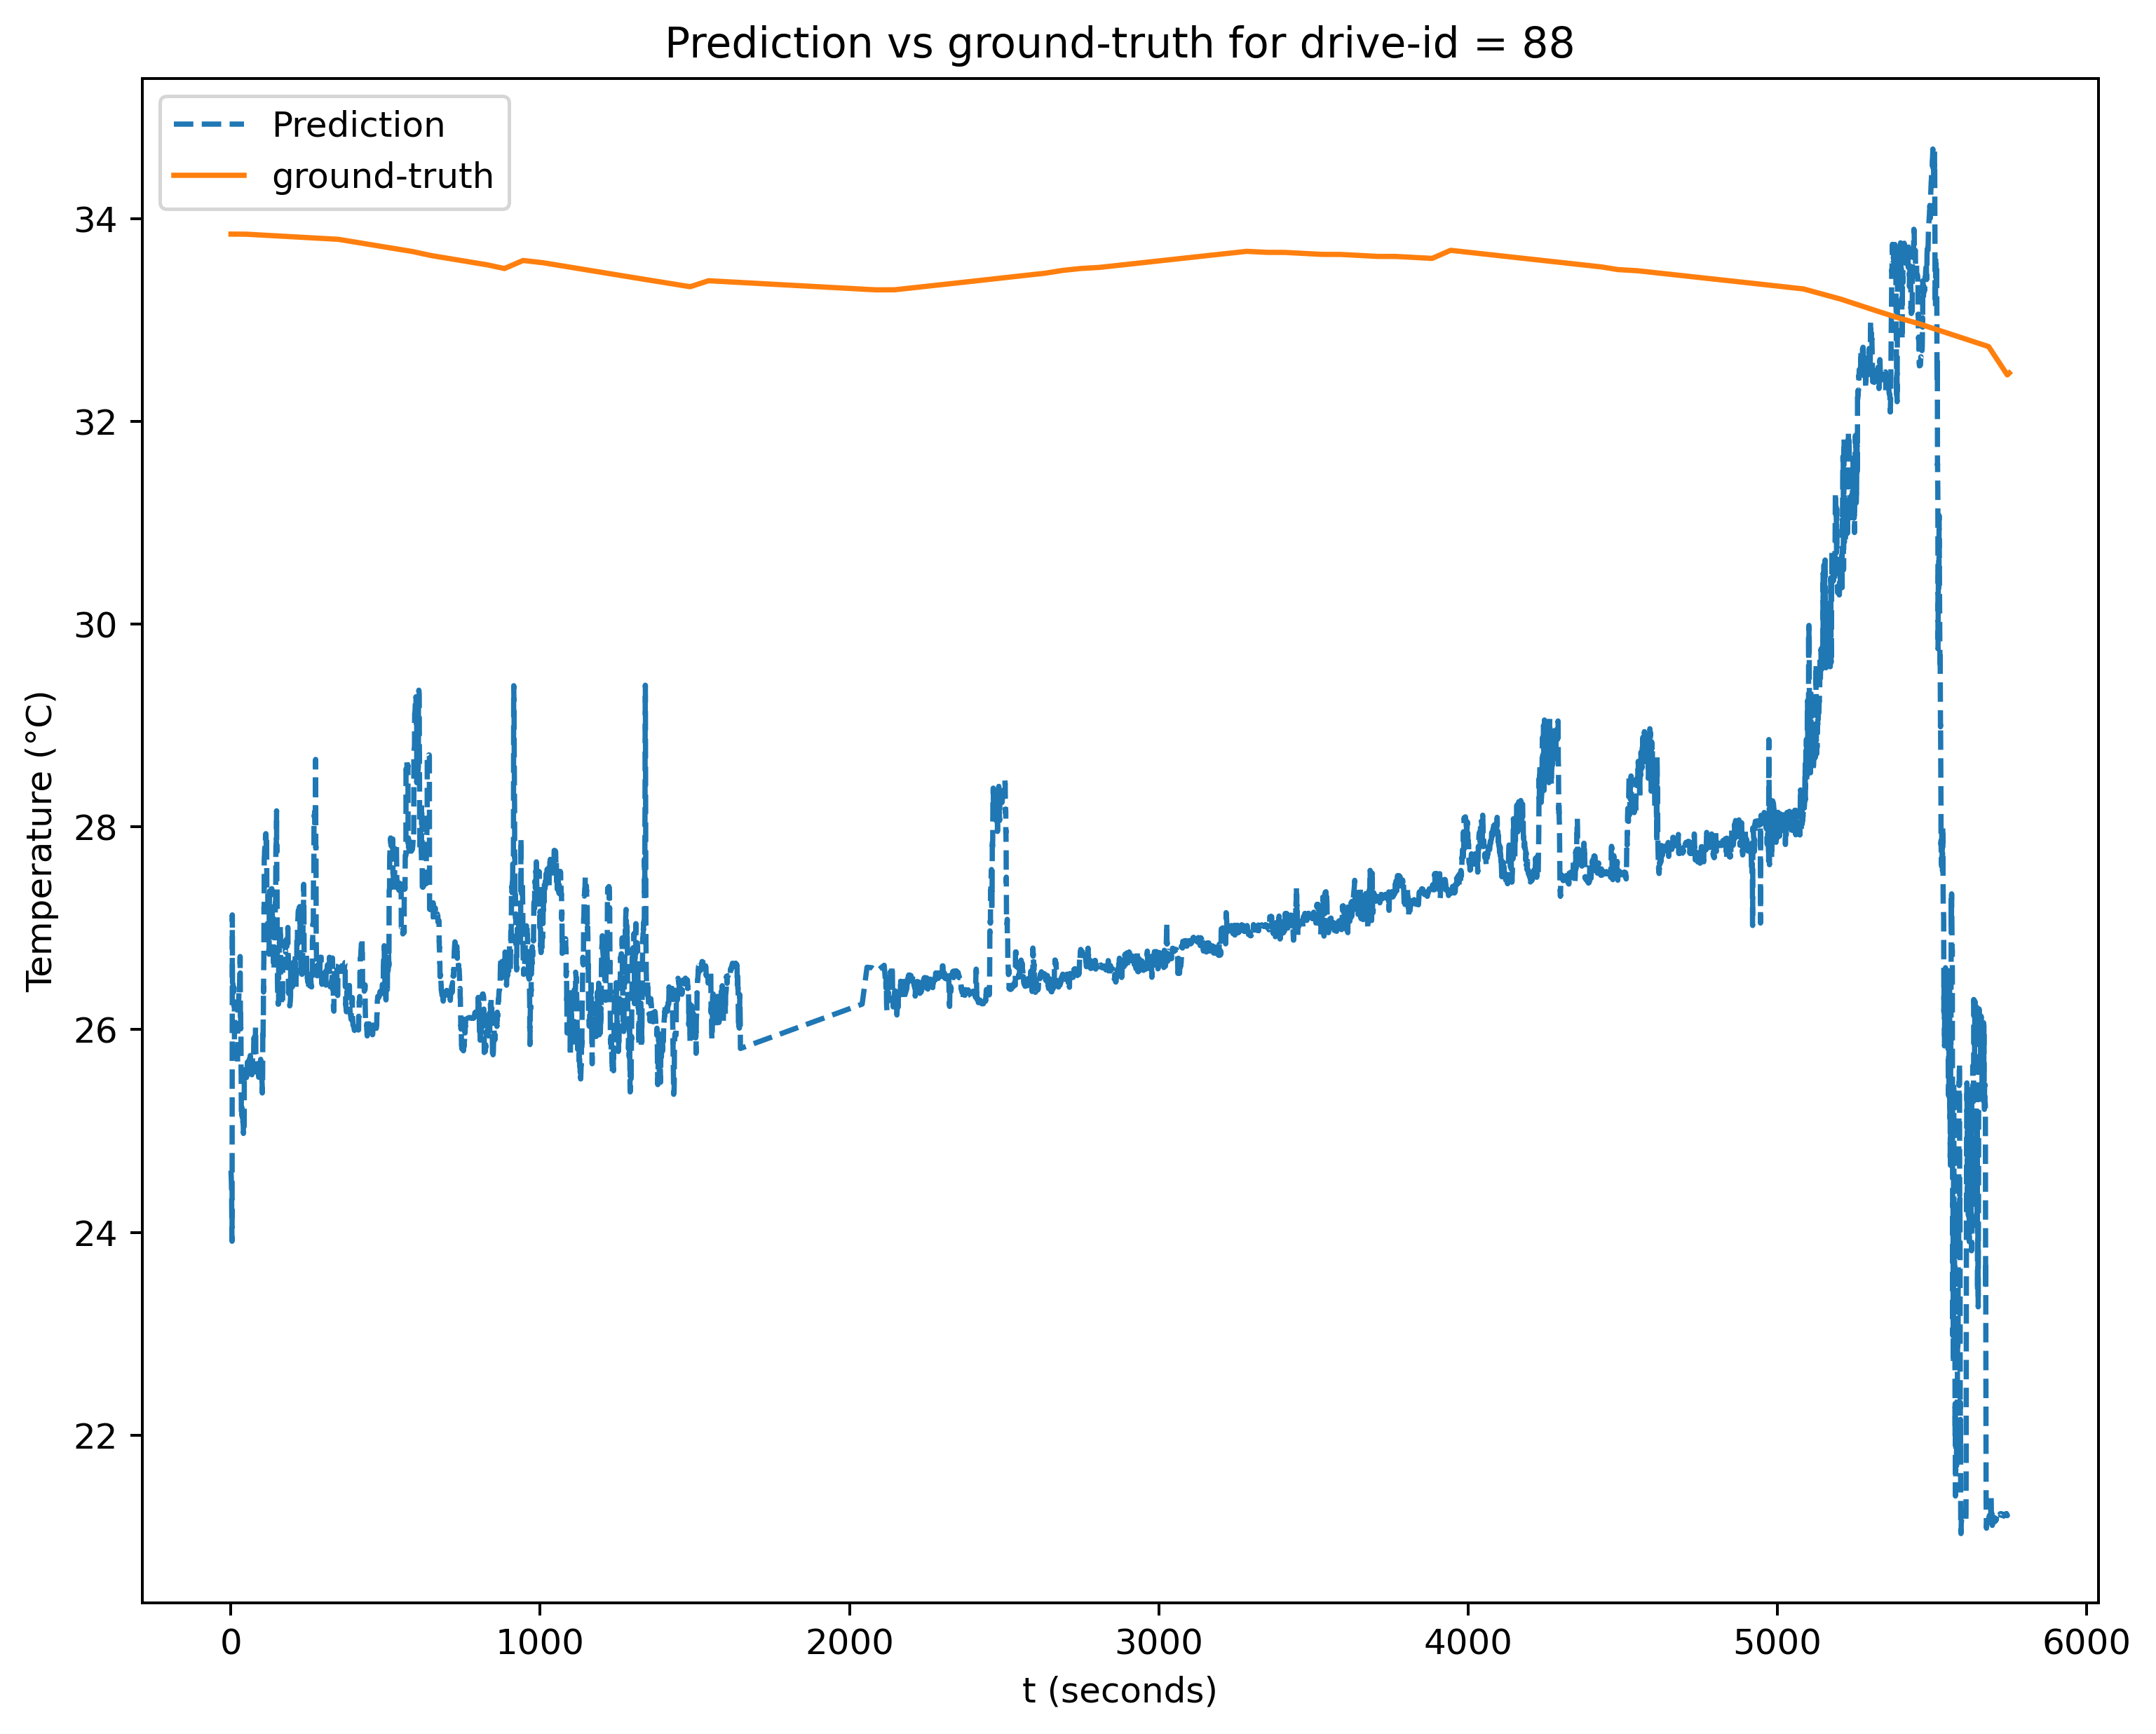

In [22]:
mae88,mse88,rel_error88 = predict(88)